<a href="https://colab.research.google.com/github/AnastasiaCotov/Correlated-Power-Analysis/blob/main/binary_read_1st%20power_trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/ES/code'
path = '/content/drive/My Drive/ES/code'

Mounted at /content/drive
/content/drive/My Drive/ES/code


In [2]:
%matplotlib inline
import matplotlib.pylab as plt
from traces_bin_reader.TracesBin import TracesBin
import numpy as np

In [3]:
#f= TracesBin("../../traces_CW305/Artix7-100t/0_95V/50MHz/2021-09-21/2021-09-21_50MHz_125MSa_12bit_k0-00_1k.dat")
f = TracesBin("2021-10-25_100t_duDFS_VCC-1.00_freq-50.000MHz_125MSa_12bit_k0-01_1k.dat")
#f= TracesBin("2021-10-25_100t_duDFS_VCC-1.00_freq-50.000MHz_125MSa_12bit_k0-00_1k.dat")

# Data Visualization

In [4]:
#this one to check guessed key I think
assert int.from_bytes(f.getKey(), 'big') == 0x007e151628aed2a6abf7158809cf4f3c

AssertionError: ignored

In [7]:
assert f.getNTraces() == 500
assert f.getNSamples() == 134016

In [8]:
data, plain = f.getAllTraces()

In [9]:
print(data)
print(data.shape)

[[ -921.   -65. -1680. ...  -501.   355.  1372.]
 [-1228.  -582. -2083. ...  -307.   468.  1275.]
 [-1438.  -582. -2229. ...  -420.   581.  1356.]
 ...
 [-1179.  -953. -2083. ...  -210.   516.  1097.]
 [ -953.  -792. -2309. ...     0.   904.   968.]
 [-1357. -1131. -2229. ...   -81.   888.  1210.]]
(500, 134016)


In [10]:
print(plain)
print(plain.shape)

[[158  36   8 ... 216 178  16]
 [105  88 155 ... 113 152  96]
 [118 190  89 ... 221 181   4]
 ...
 [247 244 136 ... 255 164 219]
 [127  59 109 ...  17  19 173]
 [184   0 103 ...  22 130  23]]
(500, 16)


In [13]:
assert int.from_bytes(plain[0], 'big') == 0x4e83db96249048278c2278e8583c283e

AssertionError: ignored

In [53]:
#data0, plain0 = f.getTraces([0])

data0 = data[0]
plain0 = plain[0]
print(data0)
print(plain0)
print(data[0])
print(plain[0])

print(data0.shape)
print(plain0.shape)
print(data[0].shape)
print(plain[0].shape)

assert all(data0==data[0])
assert all(plain0==plain[0])

print(data0[0])
print(plain0[0])

[ -921.   -65. -1680. ...  -501.   355.  1372.]
[158  36   8  33 222  33 135 194 190 132  73  59 190 216 178  16]
[ -921.   -65. -1680. ...  -501.   355.  1372.]
[158  36   8  33 222  33 135 194 190 132  73  59 190 216 178  16]
(134016,)
(16,)
(134016,)
(16,)
-921.0
158


In [94]:
print(len(data0))
print("✔️")

134016
✔️


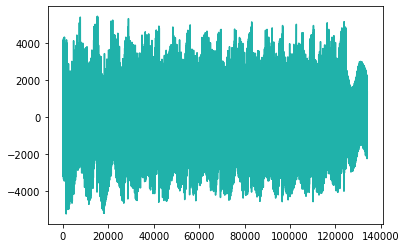

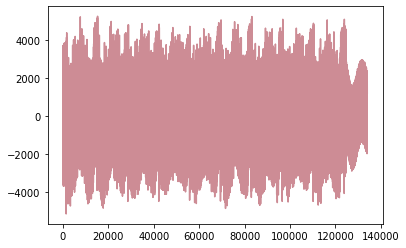

In [90]:
plt.figure()
plt.plot(data[0], '#20B2AA')
plt.figure()
plt.plot(data[499], '#CD8C95')
plt.show()


In [12]:
data[0]

array([ -921.,   -65., -1680., ...,  -501.,   355.,  1372.], dtype=float32)

In [96]:
data0

array([ -921.,   -65., -1680., ...,  -501.,   355.,  1372.], dtype=float32)

In [50]:
plain[:2]

array([[158,  36,   8,  33, 222,  33, 135, 194, 190, 132,  73,  59, 190,
        216, 178,  16],
       [105,  88, 155,  11, 105,  98,  75, 109, 180, 117, 117,  11, 171,
        113, 152,  96]], dtype=uint8)

In [25]:
plain0

array([[158,  36,   8,  33, 222,  33, 135, 194, 190, 132,  73,  59, 190,
        216, 178,  16]], dtype=uint8)

# AES Model and Hamming Weight

we’ll need to be able to easily grab what the sbox output will be for a given plaintext and key, as well as get the hamming weight of numbers between 0 and 255:


https://github.com/prki/Correlation-power-analysis/blob/master/src/AES_CPA.py# 

https://github.com/skoppula/aes-sidechannel/blob/master/cpa/cpa.py

In [14]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]


In [15]:
# XOR between plaintext and hypothetical key
def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

In [16]:
# count 1's HW
HW = [bin(n).count("1") for n in range(0, 256)]

In [17]:
#Hypothetical keys:
corrKeyList = [0 for x in range(16)]

Verify that the model is correct:

In [18]:
# plain = 0xC7 and hypothetical key = 0x00
assert HW[aes_internal(0xC7, 0x00)] == 4
assert HW[aes_internal(0xA1, 0x79)] == 3
assert HW[aes_internal(0x22, 0xB1)] == 5
print("✔️ ")

✔️ 


# Correlation Algorithm
https://chipwhisperer.readthedocs.io/en/latest/tutorials/courses_sca101_soln_lab%204_2%20-openadc-cwlitearm.html#tutorial-courses-sca101-soln-lab-4-2-openadc-cwlitearm

how good our guess is using a measurement called the **Pearson** correlation coefficient, which measures the linear correlation between two datasets.








The actual algorithm is as follows for datasets X and Y of length , with means of
X* and Y*, respectively:

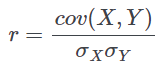

The covariance of X and Y and can be calculated as follows:

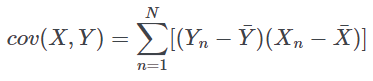

standard deviation of the two datasets:

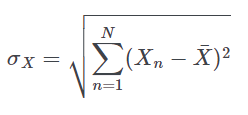

 To start, build the following functions:


*   mean(X) to calculate the mean of a dataset

*   std_dev(X, X_bar) to calculate the standard deviation of a dataset. We’ll need to reuse the mean for the covariance, so it makes more sense to calculate it once and pass it in to each function


*   cov(X, X_bar, Y, Y_bar) to calculate the covariance of two datasets. Again, we can just pass in the means we calculate for std_dev here.



In [19]:
def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

checking if it works

In [62]:
a = np.array([[5, 3, 4, 4, 5, 6],
             [27, 2, 3, 4, 12, 6],
              [1, 3, 5, 4, 5, 6],
              [1, 2, 3, 4, 5, 6],
             ]).transpose()
a_bar = mean(a)
b = np.array([[5, 4, 3, 2, 1, 3]]).transpose()
b_bar = mean(b)

o_a = std_dev(a, a_bar)
o_b = std_dev(b, b_bar)

ab_cov = cov(a, a_bar, b, b_bar)

In [63]:
assert (a_bar == np.array([4.5, 9., 4., 3.5])).all()
assert (b_bar == np.array([3.])).all()
assert (o_a[3] > 4.1833001 and o_a[3] < 4.1833002)
assert (o_b[0] > 3.162277 and o_b[0] < 3.162278)
assert (ab_cov == np.array([-1., 28., -9., -10.])).all()
print("✔️ ")

✔️ 


In [64]:
print(data)


[[ -921.   -65. -1680. ...  -501.   355.  1372.]
 [-1228.  -582. -2083. ...  -307.   468.  1275.]
 [-1438.  -582. -2229. ...  -420.   581.  1356.]
 ...
 [-1179.  -953. -2083. ...  -210.   516.  1097.]
 [ -953.  -792. -2309. ...     0.   904.   968.]
 [-1357. -1131. -2229. ...   -81.   888.  1210.]]


Like with the DPA attack, we don’t know where the encryption is occurring, meaning we have to repeat the correlation calculation for each column in the trace array, with the largest correlation being our best guess for where the SBox output is happening. We obviously also don’t know the key (that’s the thing we’re trying to find!), so we’ll also need to repeat the best correlation calculation for each possible value of key[0] (0 to 255). The key with the highest absolute correlation is our best guess for the value of the key byte.

A really nice feature of numpy is that we can do the correlation calculations across the entire trace at once (mean, std_dev, cov). That means there’s no need to do:

In [20]:
#len(data0) same as
print(data[0])
len(data[0])

[ -921.   -65. -1680. ...  -501.   355.  1372.]


134016

In [21]:
t_bar = []
for point_num in range(len(data[0])):
    t_bar.append(mean(data[:,point_num]))
    # and so on...

t_bar = np.array(t_bar)
t_bar

array([-1186.07 , -1033.652, -2151.562, ...,  -163.514,   680.974,
        1099.716])

In [22]:
t_bar = mean(data)
t_bar

array([-1186.07 , -1033.652, -2151.562, ...,  -163.514,   680.974,
        1099.716], dtype=float32)

In [23]:
t_bar.transpose()


array([-1186.07 , -1033.652, -2151.562, ...,  -163.514,   680.974,
        1099.716], dtype=float32)

[
      
      [HW[aes_internal(plaintext0[0], key[0])], # trace 0
      [HW[aes_internal(plaintext1[0], key[0])], # trace 1
      [HW[aes_internal(plaintext2[0], key[0])], # trace 2
      ...
]

In [25]:
kguess = 0xf1
n = aes_internal(0x10,kguess)
n

248

In [26]:

HW[n]

5

In [28]:
plain[0]

array([158,  36,   8,  33, 222,  33, 135, 194, 190, 132,  73,  59, 190,
       216, 178,  16], dtype=uint8)

In [29]:
int(plain0[0])

158

In [68]:
# we don't need to redo the mean and std dev calculations
# for each key guess
t_bar = mean(data)
o_t = std_dev(data, t_bar)

print(t_bar)
print(o_t)


[-1186.07  -1033.652 -2151.562 ...  -163.514   680.974  1099.716]
[4238.9062 9511.653  3806.2178 ... 5398.927  7065.854  6110.6577]


In [69]:
def guessByte(x):
  for kguess in tnrange(0, 256):
      hws = np.array([[HW[aes_internal(x, kguess)] for plain in plain]]).transpose()
      hws_bar = mean(hws)
      o_hws = std_dev(hws, hws_bar)
      correlation = cov(data, t_bar, hws, hws_bar)
      cpaoutput = correlation/(o_t*o_hws)
      maxcpa[kguess] = max(abs(cpaoutput))
  guess = np.argmax(maxcpa)
  guess_corr = max(maxcpa)

  print("Key guess: ", hex(guess))
  print("Correlation: ", guess_corr)
  return guess, gues_corr

In [85]:
for i in tnrange(0, 16):

  print(i,' plain text ', plain[i])
  for kguess in tnrange(0, 256):
      hws = np.array([[HW[aes_internal(plain[i], kguess)] for plain in plain]]).transpose()
      hws_bar = mean(hws)
      o_hws = std_dev(hws, hws_bar)
      correlation = cov(data, t_bar, hws, hws_bar)
      cpaoutput = correlation/(o_t*o_hws)
      maxcpa[kguess] = max(abs(cpaoutput))

  guess = np.argmax(maxcpa)
  guess_corr = max(maxcpa)

  print("Key guess: ", i," ", hex(guess))
  print("Correlation: ", guess_corr)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """Entry point for launching an IPython kernel.


  0%|          | 0/16 [00:00<?, ?it/s]

0  plain text  [158  36   8  33 222  33 135 194 190 132  73  59 190 216 178  16]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  after removing the cwd from sys.path.


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  0   0x1
Correlation:  0.6032978932315594
1  plain text  [105  88 155  11 105  98  75 109 180 117 117  11 171 113 152  96]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  1   0x7e
Correlation:  0.5823065427754854
2  plain text  [118 190  89  30  86 104 248  70 224 121   4  99  26 221 181   4]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  2   0x15
Correlation:  0.5722236524754283
3  plain text  [240 173 136 161 194 172  29  19  12  68  18  40  11 163 156 105]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  3   0x16
Correlation:  0.5780214491814588
4  plain text  [181 205  87  69 197  20  33  78 168 169  66 104  48 192 190 188]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  4   0x28
Correlation:  0.5958702276506902
5  plain text  [240 175  99 148 217 234  34  32 135 246  38 145 244 103  67 165]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  5   0xae
Correlation:  0.5736390538149848
6  plain text  [ 86  58  32 221  63  12 203 202 125 177  10 198 233   7  27 171]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  6   0xd2
Correlation:  0.5927213842221626
7  plain text  [156 161  22 113  26 109 121 209 122 166 165  96  70 148 203 130]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  7   0xa6
Correlation:  0.5867713058294263
8  plain text  [129 192 230  11 117 167 172 180 184  58 220 195  96  45  49 128]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  8   0xab
Correlation:  0.5765636169247043
9  plain text  [122 247 105 186 179  38   4  33 226 155 227  88 143 128 134 114]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  9   0xf7
Correlation:  0.5594226412659872
10  plain text  [131 191 137 247 146 103   1  79 140  36 225  63  97 247 207 207]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  10   0x15
Correlation:  0.6546829756448238
11  plain text  [ 55 165  62 111 192 113 112  22 155 251 167 136 182 123  20 147]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  11   0x88
Correlation:  0.6001999877423914
12  plain text  [180 164  21 172 143 237 166 223 193  15 246  21 176 226 213 205]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  12   0x9
Correlation:  0.5554081889256651
13  plain text  [ 67 232 183 150 245 143 255 199 101 158 143 142 130 141 163  82]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  13   0xcf
Correlation:  0.6038534225241822
14  plain text  [ 16 219   6 182  57 128  49 165  67   0  31 207 111  22 178 251]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  14   0x4f
Correlation:  0.6038459964608957
15  plain text  [  9 190  90 200 148 199  54 177 137 150 162 148 111 208  49 104]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  15   0x3c
Correlation:  0.5419131948428231


In [107]:
the_key = []

In [132]:
from array import *
my_array = array('i', [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
for i in range(16):
  print(my_array[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [135]:
for i in tnrange(0, 16):

  print(i,' plain text ', plain[i])
  for kguess in tnrange(0, 256):
      hws = np.array([[HW[aes_internal(plain[i], kguess)] for plain in plain]]).transpose()
      hws_bar = mean(hws)
      o_hws = std_dev(hws, hws_bar)
      correlation = cov(data, t_bar, hws, hws_bar)
      cpaoutput = correlation/(o_t*o_hws)
      #print(kguess,' cpaoutput ', cpaoutput)
      maxcpa[kguess] = max(abs(cpaoutput))
      #print(' max cpa kguess = ', maxcpa[kguess])


  guess = np.argmax(maxcpa)
  guess_corr = max(maxcpa)

  print("Key guess: ", i," ", hex(guess))
  print("Correlation: ", guess_corr)
  my_array[i] = guess
  print("the partial key = ", my_array)

print("the key = ", my_array)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """Entry point for launching an IPython kernel.


  0%|          | 0/16 [00:00<?, ?it/s]

0  plain text  [158  36   8  33 222  33 135 194 190 132  73  59 190 216 178  16]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  after removing the cwd from sys.path.


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  0   0x1
Correlation:  0.6032978932315594
the partial key =  array('i', [1, 126, 21, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
1  plain text  [105  88 155  11 105  98  75 109 180 117 117  11 171 113 152  96]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  1   0x7e
Correlation:  0.5823065427754854
the partial key =  array('i', [1, 126, 21, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
2  plain text  [118 190  89  30  86 104 248  70 224 121   4  99  26 221 181   4]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  2   0x15
Correlation:  0.5722236524754283
the partial key =  array('i', [1, 126, 21, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
3  plain text  [240 173 136 161 194 172  29  19  12  68  18  40  11 163 156 105]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  3   0x16
Correlation:  0.5780214491814588
the partial key =  array('i', [1, 126, 21, 22, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
4  plain text  [181 205  87  69 197  20  33  78 168 169  66 104  48 192 190 188]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  4   0x28
Correlation:  0.5958702276506902
the partial key =  array('i', [1, 126, 21, 22, 40, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
5  plain text  [240 175  99 148 217 234  34  32 135 246  38 145 244 103  67 165]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  5   0xae
Correlation:  0.5736390538149848
the partial key =  array('i', [1, 126, 21, 22, 40, 174, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
6  plain text  [ 86  58  32 221  63  12 203 202 125 177  10 198 233   7  27 171]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  6   0xd2
Correlation:  0.5927213842221626
the partial key =  array('i', [1, 126, 21, 22, 40, 174, 210, 7, 8, 9, 10, 11, 12, 13, 14, 15])
7  plain text  [156 161  22 113  26 109 121 209 122 166 165  96  70 148 203 130]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  7   0xa6
Correlation:  0.5867713058294263
the partial key =  array('i', [1, 126, 21, 22, 40, 174, 210, 166, 8, 9, 10, 11, 12, 13, 14, 15])
8  plain text  [129 192 230  11 117 167 172 180 184  58 220 195  96  45  49 128]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  8   0xab
Correlation:  0.5765636169247043
the partial key =  array('i', [1, 126, 21, 22, 40, 174, 210, 166, 171, 9, 10, 11, 12, 13, 14, 15])
9  plain text  [122 247 105 186 179  38   4  33 226 155 227  88 143 128 134 114]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  9   0xf7
Correlation:  0.5594226412659872
the partial key =  array('i', [1, 126, 21, 22, 40, 174, 210, 166, 171, 247, 10, 11, 12, 13, 14, 15])
10  plain text  [131 191 137 247 146 103   1  79 140  36 225  63  97 247 207 207]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  10   0x15
Correlation:  0.6546829756448238
the partial key =  array('i', [1, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 11, 12, 13, 14, 15])
11  plain text  [ 55 165  62 111 192 113 112  22 155 251 167 136 182 123  20 147]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  11   0x88
Correlation:  0.6001999877423914
the partial key =  array('i', [1, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 12, 13, 14, 15])
12  plain text  [180 164  21 172 143 237 166 223 193  15 246  21 176 226 213 205]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  12   0x9
Correlation:  0.5554081889256651
the partial key =  array('i', [1, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 13, 14, 15])
13  plain text  [ 67 232 183 150 245 143 255 199 101 158 143 142 130 141 163  82]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  13   0xcf
Correlation:  0.6038534225241822
the partial key =  array('i', [1, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 14, 15])
14  plain text  [ 16 219   6 182  57 128  49 165  67   0  31 207 111  22 178 251]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  14   0x4f
Correlation:  0.6038459964608957
the partial key =  array('i', [1, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 15])
15  plain text  [  9 190  90 200 148 199  54 177 137 150 162 148 111 208  49 104]


  0%|          | 0/256 [00:00<?, ?it/s]

Key guess:  15   0x3c
Correlation:  0.5419131948428231
the partial key =  array('i', [1, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60])
the key =  array('i', [1, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60])


In [163]:
a = [1, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60]
for i in range(len(a)):
  print(hex( a[i]))


0x1
0x7e
0x15
0x16
0x28
0xae
0xd2
0xa6
0xab
0xf7
0x15
0x88
0x9
0xcf
0x4f
0x3c


In [166]:
assert key == 0x017e151628aed2a6abf7158809cf4f3c
print("✔️ if we would have the real key, we could verify the result")

NameError: ignored

In [91]:
int.from_bytes(plain[1], 'big')

140029006358580342114782063684379318368

In [168]:

assert int.from_bytes(plain[0], 'big') == 0x017e151628aed2a6abf7158809cf4f3c

AssertionError: ignored